# Heart Disease Prediction
### Binary Classification using Logistic Regression & Decision Tree

**Objective:** Predict whether a patient is at risk of heart disease based on clinical health data.

**Dataset:** Heart Disease UCI Dataset (Cleveland subset — 303 patients, 14 features)

**Models Used:**
- Logistic Regression (interpretable baseline)
- Decision Tree Classifier (rule-based)
- Random Forest Classifier (ensemble, for feature importance)

## 1.Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                              roc_auc_score, roc_curve, ConfusionMatrixDisplay)

sns.set_theme(style='whitegrid', palette='Set2')
plt.rcParams['figure.dpi'] = 110
plt.rcParams['figure.figsize'] = (11, 5)

## 2. Load Dataset

The **Heart Disease UCI Dataset** is loaded directly from the UCI ML Repository.
No manual download needed — it's fetched automatically via URL.

**Features:**

| Feature | Description |
|---------|-------------|
| age | Age in years |
| sex | Sex (1 = male, 0 = female) |
| cp | Chest pain type (0–3) |
| trestbps | Resting blood pressure (mm Hg) |
| chol | Serum cholesterol (mg/dl) |
| fbs | Fasting blood sugar > 120 mg/dl (1 = true) |
| restecg | Resting ECG results (0–2) |
| thalach | Maximum heart rate achieved |
| exang | Exercise-induced angina (1 = yes) |
| oldpeak | ST depression induced by exercise |
| slope | Slope of peak exercise ST segment |
| ca | Number of major vessels (0–3) |
| thal | Thalassemia type (0–3) |
| **target** | **Heart disease present (1) or absent (0)** |

In [9]:

df = pd.read_csv('./heart_disease_data.csv')

print(f'Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns')
df.head(10)

Dataset loaded: 303 rows, 14 columns


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


## 3. Data Cleaning & Preprocessing

In [10]:
print(" Dataset Info ")
print(f"Shape         : {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print()
print(df.isnull().sum()[df.isnull().sum() > 0])
print()
df.dtypes

 Dataset Info 
Shape         : (303, 14)
Missing values: 6

ca      4
thal    2
dtype: int64



age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
dtype: object

In [11]:
# Handle missing values (ca and thal have a few '?' → NaN)
print(f"Rows before dropping NaN : {len(df)}")
df.dropna(inplace=True)
print(f"Rows after  dropping NaN : {len(df)}")

# Binarise target: original has values 0-4; 0 = no disease, 1-4 = disease present
df['target'] = (df['target'] > 0).astype(int)

# Ensure correct dtypes
df['ca']   = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

print(f"\nTarget distribution:")
print(df['target'].value_counts().rename({0:'No Disease (0)', 1:'Disease (1)'}))

Rows before dropping NaN : 303
Rows after  dropping NaN : 297

Target distribution:
target
No Disease (0)    160
Disease (1)       137
Name: count, dtype: int64


In [12]:
df.describe().round(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00,297.00
mean,54.54,0.68,3.16,131.69,247.35,0.14,1.00,149.60,0.33,1.06,1.60,0.68,4.73,0.46
std,9.05,0.47,0.96,17.76,52.00,0.35,0.99,22.94,0.47,1.17,0.62,0.94,1.94,0.50
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.00,0.00,0.00,1.00,0.00,3.00,0.00
50%,56.00,1.00,3.00,130.00,243.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,3.00,0.00
75%,61.00,1.00,4.00,140.00,276.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00,1.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,1.00


## 4. Exploratory Data Analysis (EDA)

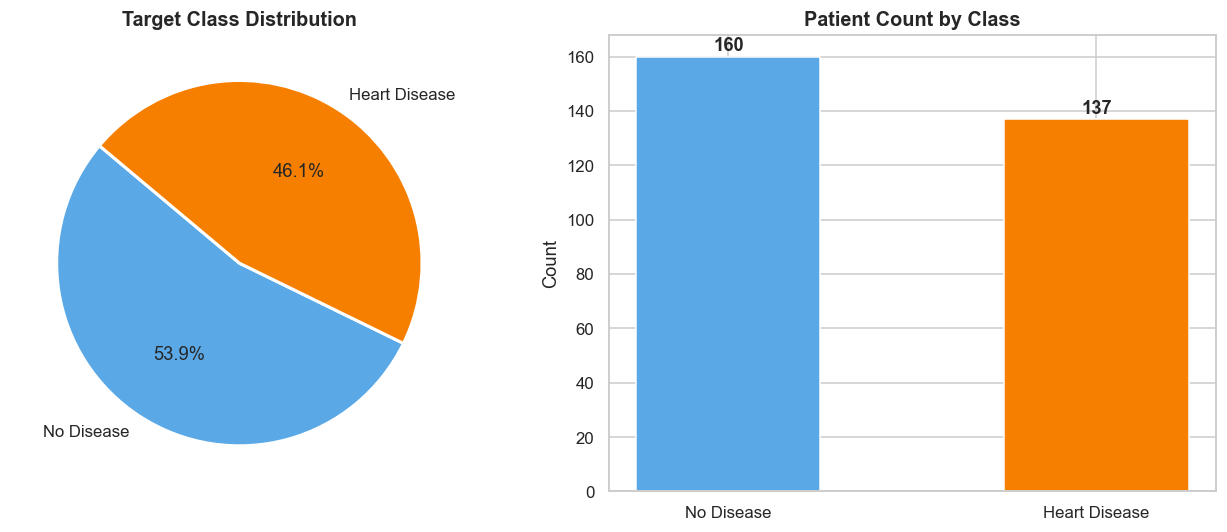

In [14]:
#  Target class balance 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

counts = df['target'].value_counts()
labels = ['No Disease', 'Heart Disease']
colors = ['#5aa9e6', '#f77f00']

axes[0].pie(counts, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=140, wedgeprops=dict(edgecolor='white', linewidth=2))
axes[0].set_title('Target Class Distribution', fontsize=13, fontweight='bold')

axes[1].bar(labels, counts.values, color=colors, edgecolor='white', width=0.5)
axes[1].set_title('Patient Count by Class', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate(counts.values):
    axes[1].text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

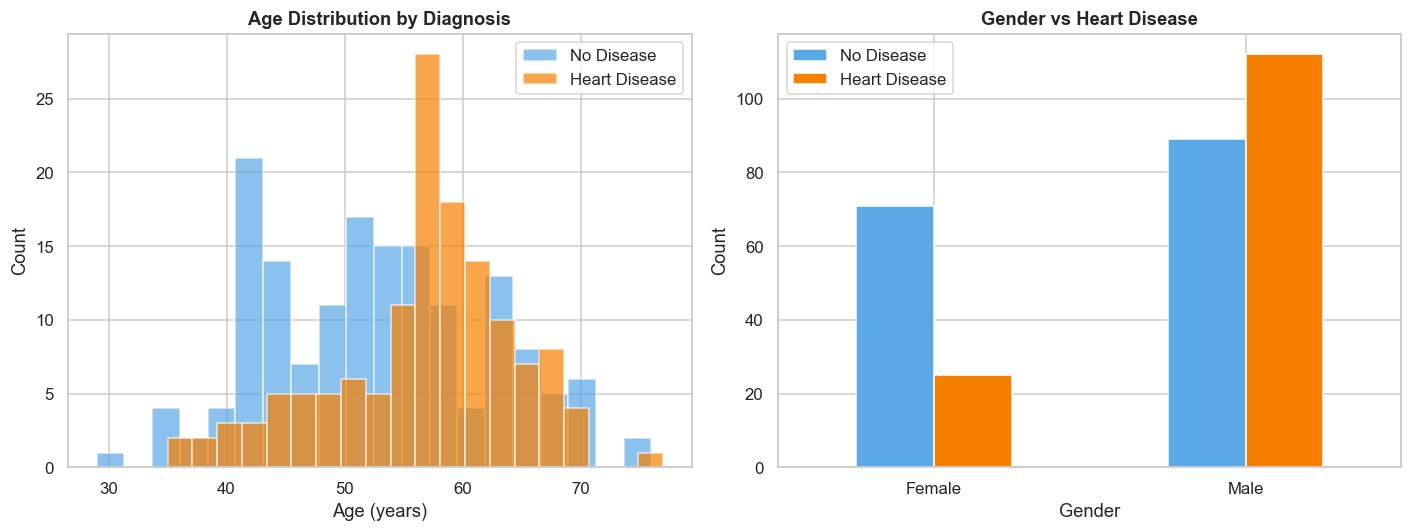

In [15]:
#  Age & gender distribution 
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Age distribution by target
for t, label, color in zip([0,1], ['No Disease','Heart Disease'], ['#5aa9e6','#f77f00']):
    axes[0].hist(df[df['target']==t]['age'], bins=20, alpha=0.7,
                 color=color, label=label, edgecolor='white')
axes[0].set_title('Age Distribution by Diagnosis', fontweight='bold')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')
axes[0].legend()

# Gender vs Heart Disease
gender_disease = df.groupby(['sex','target']).size().unstack()
gender_disease.index = ['Female','Male']
gender_disease.columns = ['No Disease','Heart Disease']
gender_disease.plot(kind='bar', ax=axes[1], color=['#5aa9e6','#f77f00'],
                    edgecolor='white', rot=0, width=0.5)
axes[1].set_title('Gender vs Heart Disease', fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

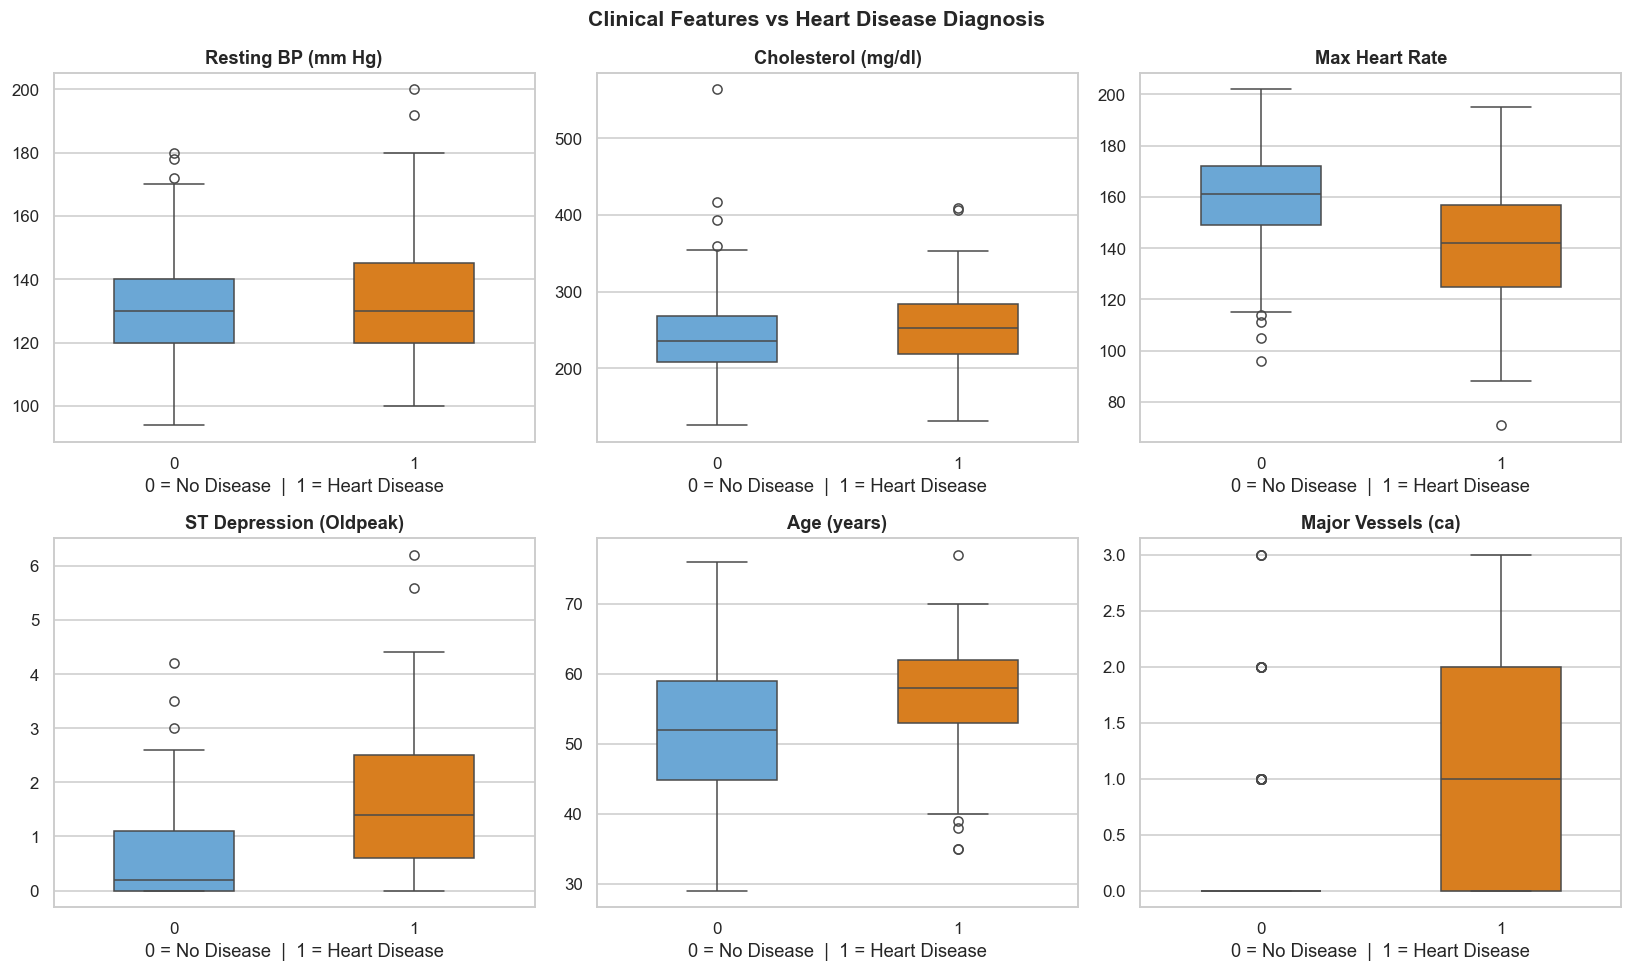

In [16]:
#  Key clinical features vs target 
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

clinical = ['trestbps','chol','thalach','oldpeak','age','ca']
titles   = ['Resting BP (mm Hg)','Cholesterol (mg/dl)',
            'Max Heart Rate','ST Depression (Oldpeak)',
            'Age (years)','Major Vessels (ca)']

for i, (feat, title) in enumerate(zip(clinical, titles)):
    sns.boxplot(data=df, x='target', y=feat, palette=['#5aa9e6','#f77f00'],
                ax=axes[i], width=0.5)
    axes[i].set_title(title, fontweight='bold')
    axes[i].set_xlabel('0 = No Disease  |  1 = Heart Disease')
    axes[i].set_ylabel('')

plt.suptitle('Clinical Features vs Heart Disease Diagnosis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

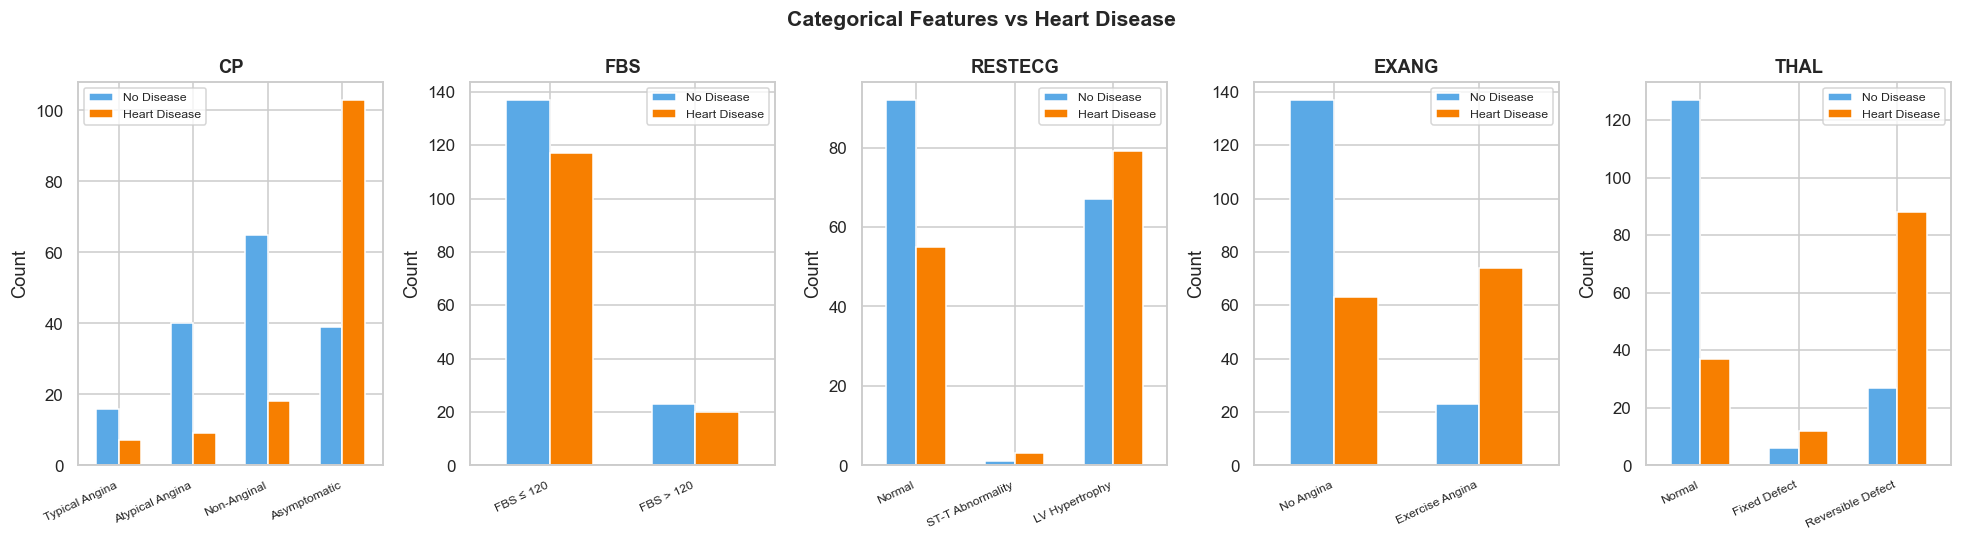

In [17]:
#  Categorical features 
cat_feats = {
    'cp'     : ['Typical Angina','Atypical Angina','Non-Anginal','Asymptomatic'],
    'fbs'    : ['FBS ≤ 120','FBS > 120'],
    'restecg': ['Normal','ST-T Abnormality','LV Hypertrophy'],
    'exang'  : ['No Angina','Exercise Angina'],
    'thal'   : ['Normal','Fixed Defect','Reversible Defect'],
}

fig, axes = plt.subplots(1, len(cat_feats), figsize=(18, 5))
for ax, (feat, xlabels) in zip(axes, cat_feats.items()):
    ct = df.groupby([feat,'target']).size().unstack(fill_value=0)
    ct.plot(kind='bar', ax=ax, color=['#5aa9e6','#f77f00'],
            edgecolor='white', rot=0, width=0.6)
    ax.set_title(feat.upper(), fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    tick_vals = range(len(xlabels[:len(ct)]))
    ax.set_xticks(list(tick_vals))
    ax.set_xticklabels(xlabels[:len(ct)], rotation=25, ha='right', fontsize=8)
    ax.legend(['No Disease','Heart Disease'], fontsize=8)

plt.suptitle('Categorical Features vs Heart Disease', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

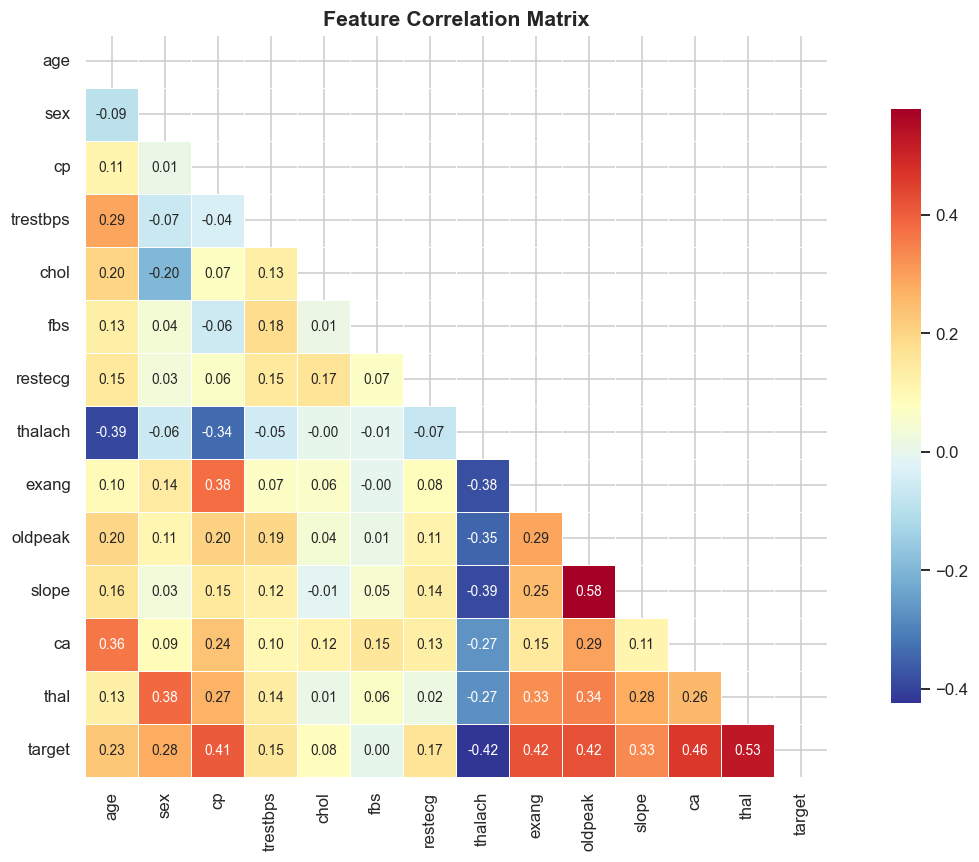

In [18]:
#  Correlation heatmap 
plt.figure(figsize=(12, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlBu_r',
            mask=mask, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 9})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Feature Engineering & Train-Test Split

In [19]:
FEATURES = ['age','sex','cp','trestbps','chol','fbs','restecg',
            'thalach','exang','oldpeak','slope','ca','thal']
TARGET   = 'target'

X = df[FEATURES]
y = df[TARGET]

# Stratified split — preserves class ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# Scale features (important for Logistic Regression)
scaler  = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f"Training samples : {len(X_train)}  ({y_train.mean()*100:.1f}% positive)")
print(f"Testing  samples : {len(X_test)}   ({y_test.mean()*100:.1f}% positive)")

Training samples : 237  (46.0% positive)
Testing  samples : 60   (46.7% positive)


## 6. Model Training

In [25]:
#  Logistic Regression 
lr = LogisticRegression(max_iter=1000, random_state=29173)
lr.fit(X_train_sc, y_train)

y_pred_lr   = lr.predict(X_test_sc)
y_prob_lr   = lr.predict_proba(X_test_sc)[:, 1]

acc_lr      = accuracy_score(y_test, y_pred_lr)
roc_lr      = roc_auc_score(y_test, y_prob_lr)
cv_lr       = cross_val_score(lr, scaler.transform(X), y, cv=StratifiedKFold(5), scoring='accuracy').mean()

print(" Logistic Regression ")
print(f"  Test Accuracy  : {acc_lr:.4f}")
print(f"  ROC-AUC Score  : {roc_lr:.4f}")
print(f"  5-Fold CV Acc  : {cv_lr:.4f}")

 Logistic Regression 
  Test Accuracy  : 0.8333
  ROC-AUC Score  : 0.9498
  5-Fold CV Acc  : 0.8247


In [24]:
#  Decision Tree 
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10,
                             random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

acc_dt    = accuracy_score(y_test, y_pred_dt)
roc_dt    = roc_auc_score(y_test, y_prob_dt)
cv_dt     = cross_val_score(dt, X, y, cv=StratifiedKFold(5), scoring='accuracy').mean()

print(" Decision Tree ")
print(f"  Test Accuracy  : {acc_dt:.4f}")
print(f"  ROC-AUC Score  : {roc_dt:.4f}")
print(f"  5-Fold CV Acc  : {cv_dt:.4f}")

 Decision Tree 
  Test Accuracy  : 0.6833
  ROC-AUC Score  : 0.7450
  5-Fold CV Acc  : 0.7272


In [26]:
#  Random Forest (for feature importance) 
rf = RandomForestClassifier(n_estimators=300, max_depth=8,
                             random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

acc_rf    = accuracy_score(y_test, y_pred_rf)
roc_rf    = roc_auc_score(y_test, y_prob_rf)
cv_rf     = cross_val_score(rf, X, y, cv=StratifiedKFold(5), scoring='accuracy').mean()

print(" Random Forest ")
print(f"  Test Accuracy  : {acc_rf:.4f}")
print(f"  ROC-AUC Score  : {roc_rf:.4f}")
print(f"  5-Fold CV Acc  : {cv_rf:.4f}")

 Random Forest 
  Test Accuracy  : 0.8667
  ROC-AUC Score  : 0.9420
  5-Fold CV Acc  : 0.8246


## 7. Model Evaluation

In [27]:
# Summary Table 
summary = pd.DataFrame({
    'Model'        : ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Test Accuracy': [acc_lr, acc_dt, acc_rf],
    'ROC-AUC'      : [roc_lr, roc_dt, roc_rf],
    'CV Accuracy'  : [cv_lr, cv_dt, cv_rf]
}).set_index('Model')

print(summary.round(4).to_string())
summary.round(4)

                     Test Accuracy  ROC-AUC  CV Accuracy
Model                                                   
Logistic Regression         0.8333   0.9498       0.8247
Decision Tree               0.6833   0.7450       0.7272
Random Forest               0.8667   0.9420       0.8246


,Test Accuracy,ROC-AUC,CV Accuracy
Model,,,
Logistic Regression,0.8333,0.9498,0.8247
Decision Tree,0.6833,0.7450,0.7272
Random Forest,0.8667,0.9420,0.8246


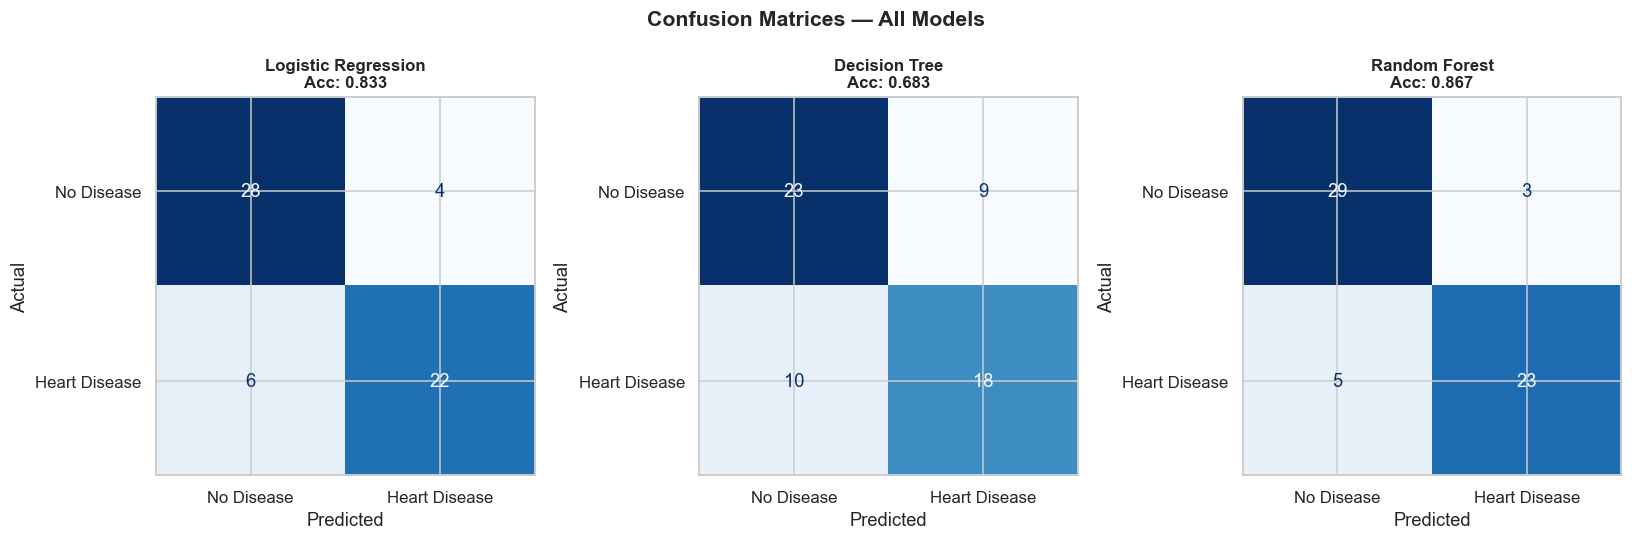

In [28]:
#  Confusion Matrices 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models_preds = [
    ('Logistic Regression', y_pred_lr, '#5aa9e6'),
    ('Decision Tree',       y_pred_dt, '#f77f00'),
    ('Random Forest',       y_pred_rf, '#57cc99'),
]
for ax, (name, preds, color) in zip(axes, models_preds):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['No Disease','Heart Disease'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'{name}\nAcc: {accuracy_score(y_test,preds):.3f}',
                 fontweight='bold', fontsize=11)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle('Confusion Matrices — All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

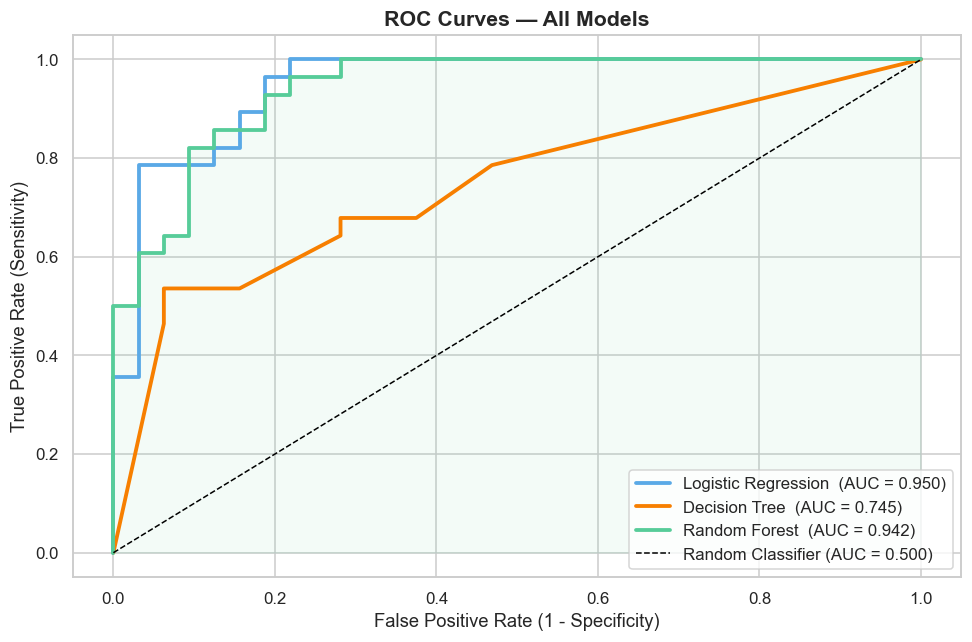

In [29]:
#  ROC Curves 
plt.figure(figsize=(9, 6))
models_roc = [
    ('Logistic Regression', y_prob_lr, '#5aa9e6', roc_lr),
    ('Decision Tree',       y_prob_dt, '#f77f00', roc_dt),
    ('Random Forest',       y_prob_rf, '#57cc99', roc_rf),
]
for name, probs, color, auc in models_roc:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, color=color, linewidth=2.5,
             label=f'{name}  (AUC = {auc:.3f})')

plt.plot([0,1],[0,1],'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')
plt.fill_between(*roc_curve(y_test, y_prob_rf)[:2], alpha=0.07, color='#57cc99')
plt.title('ROC Curves — All Models', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [31]:
#  Classification Reports 
for name, preds in [('Logistic Regression', y_pred_lr),
                    ('Decision Tree',       y_pred_dt),
                    ('Random Forest',       y_pred_rf)]:
    print(f" {name} ")
    print(classification_report(y_test, preds,
          target_names=['No Disease','Heart Disease']))

 Logistic Regression 
               precision    recall  f1-score   support

   No Disease       0.82      0.88      0.85        32
Heart Disease       0.85      0.79      0.81        28

     accuracy                           0.83        60
    macro avg       0.83      0.83      0.83        60
 weighted avg       0.83      0.83      0.83        60

 Decision Tree 
               precision    recall  f1-score   support

   No Disease       0.70      0.72      0.71        32
Heart Disease       0.67      0.64      0.65        28

     accuracy                           0.68        60
    macro avg       0.68      0.68      0.68        60
 weighted avg       0.68      0.68      0.68        60

 Random Forest 
               precision    recall  f1-score   support

   No Disease       0.85      0.91      0.88        32
Heart Disease       0.88      0.82      0.85        28

     accuracy                           0.87        60
    macro avg       0.87      0.86      0.87        60
 we

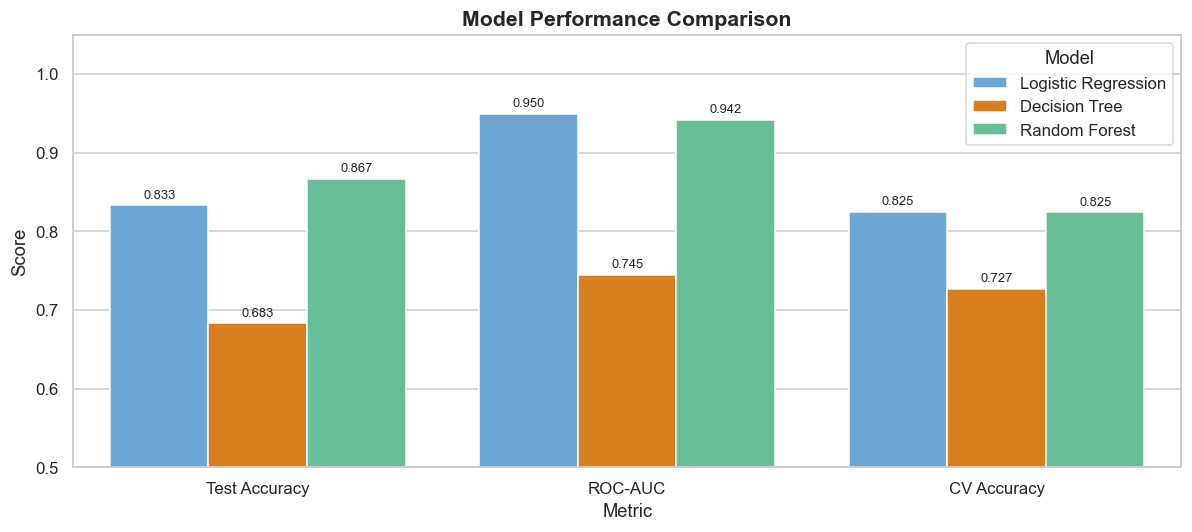

In [32]:
#  Bar chart: metric comparison 
metrics_df = summary.reset_index().melt(id_vars='Model',
             var_name='Metric', value_name='Score')

plt.figure(figsize=(11, 5))
ax = sns.barplot(data=metrics_df, x='Metric', y='Score', hue='Model',
                 palette=['#5aa9e6','#f77f00','#57cc99'], edgecolor='white')
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8.5)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.05)
plt.ylabel('Score')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

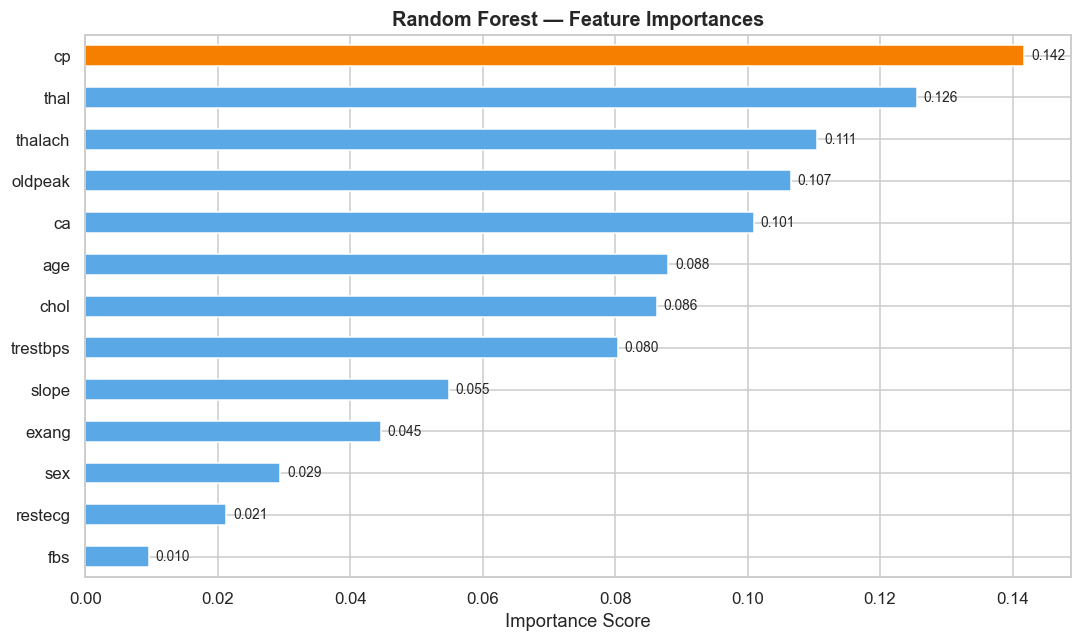

Top 5 Most Important Features:
cp         0.1418
thal       0.1256
thalach    0.1105
oldpeak    0.1066
ca         0.1010
dtype: float64


In [33]:
#  Random Forest Feature Importance 
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=True)
top_color   = ['#f77f00' if v == importances.max() else '#5aa9e6' for v in importances]

fig, ax = plt.subplots(figsize=(10, 6))
bars = importances.plot(kind='barh', ax=ax, color=top_color, edgecolor='white')
ax.set_title('Random Forest — Feature Importances', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
for i, v in enumerate(importances):
    ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)
plt.tight_layout()
plt.show()

print("Top 5 Most Important Features:")
print(importances.sort_values(ascending=False).head(5).round(4))

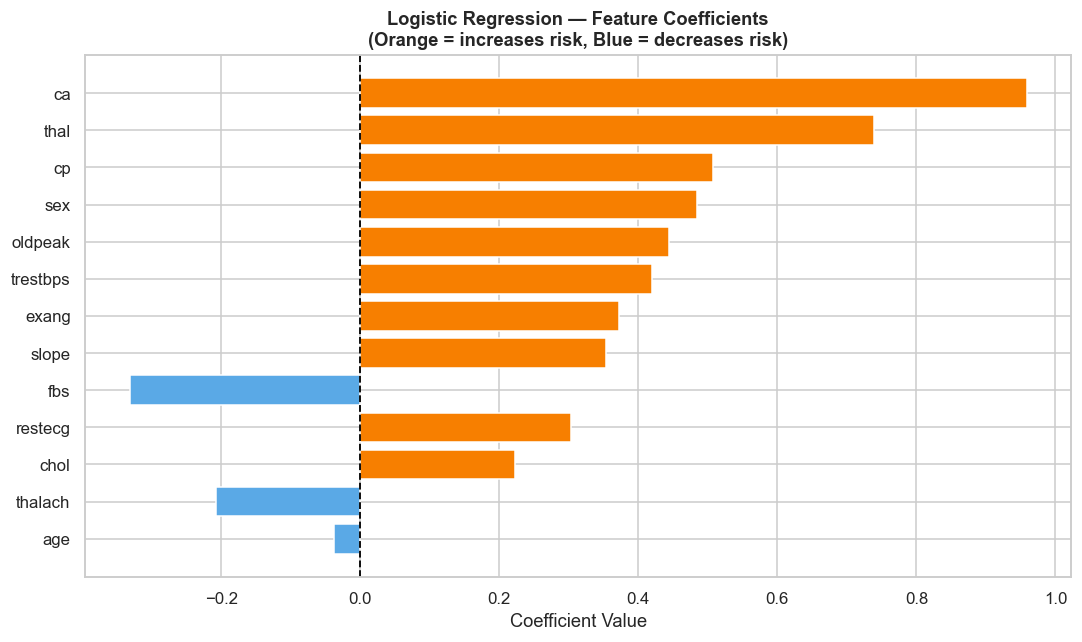

In [34]:
#  Logistic Regression Coefficients 
coef_df = pd.DataFrame({'Feature': FEATURES,
                         'Coefficient': lr.coef_[0]})
coef_df['Abs'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs', ascending=True)

colors_lr = ['#f77f00' if c > 0 else '#5aa9e6' for c in coef_df['Coefficient']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors_lr, edgecolor='white')
ax.axvline(0, color='black', linewidth=1.2, linestyle='--')
ax.set_title('Logistic Regression — Feature Coefficients\n(Orange = increases risk, Blue = decreases risk)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

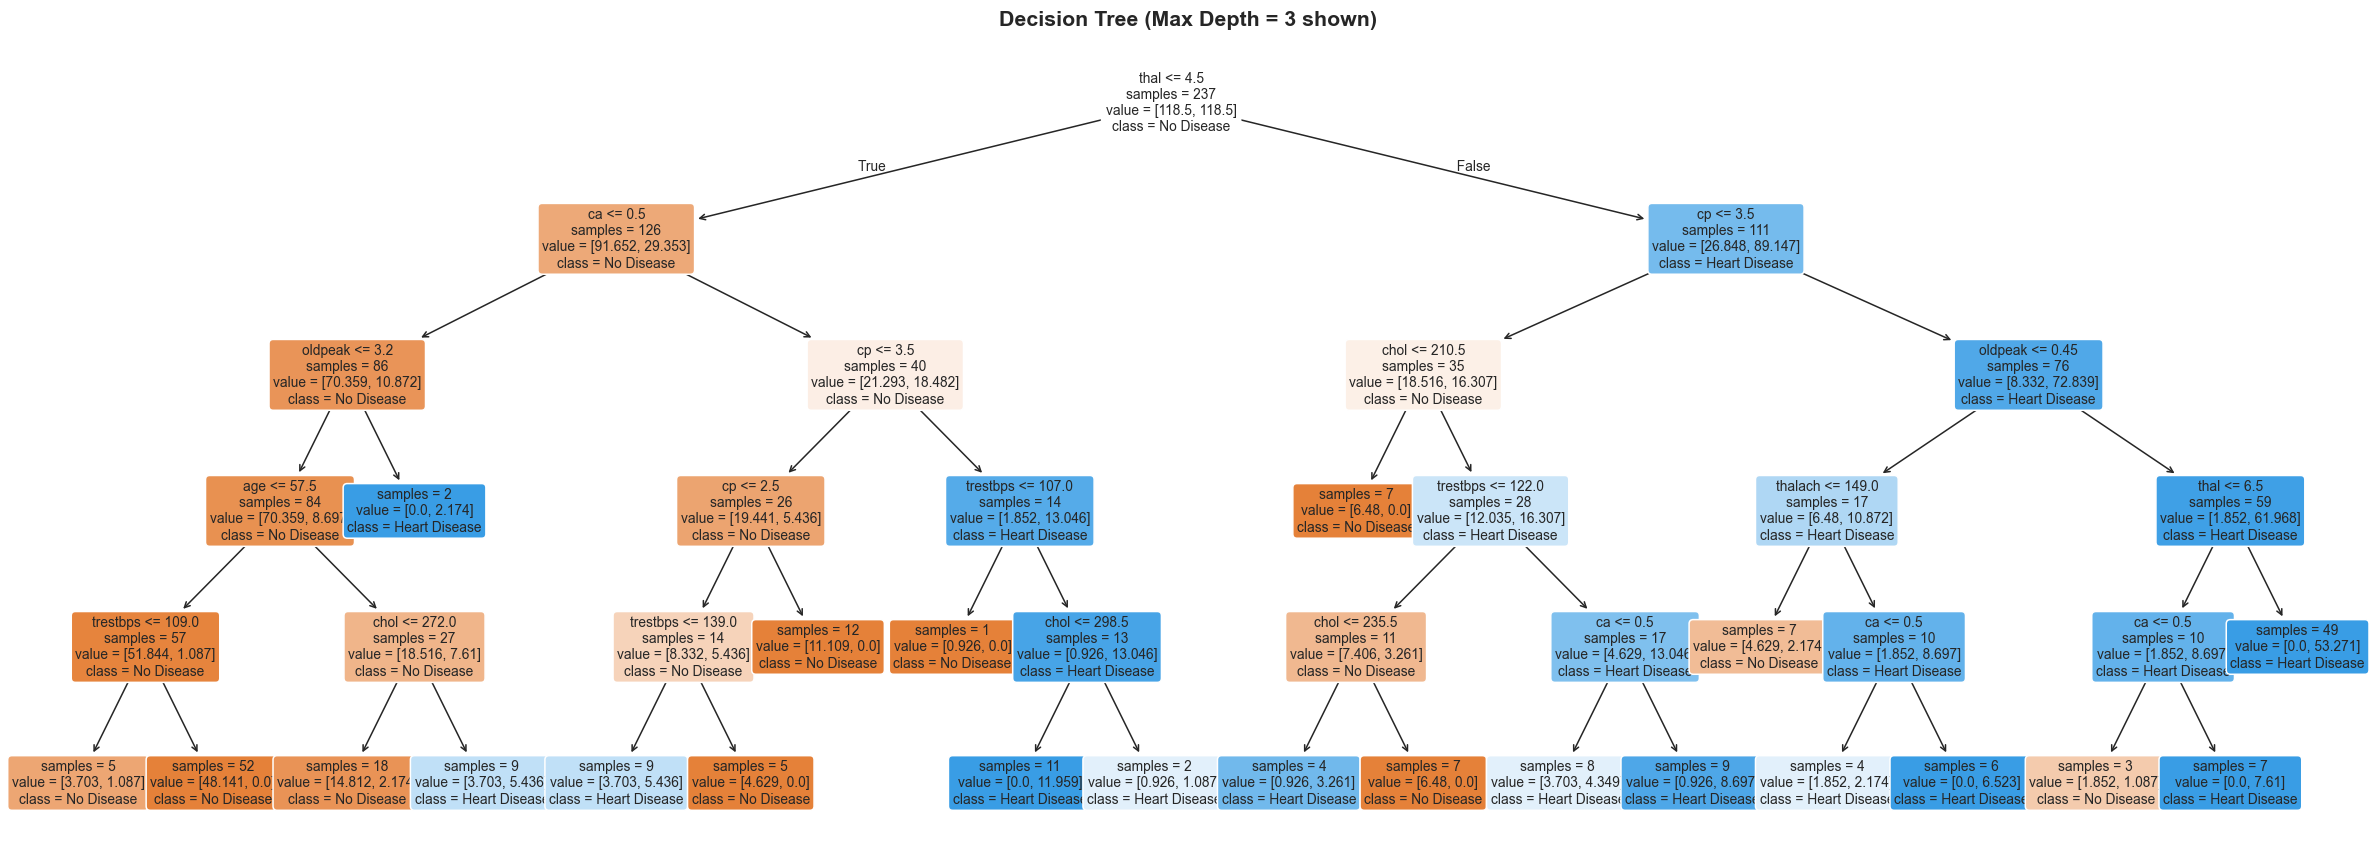

In [36]:
#  Decision Tree Visualization 
plt.figure(figsize=(22, 8))
plot_tree(dt, feature_names=FEATURES,
          class_names=['No Disease','Heart Disease'],
          filled=True, rounded=True, fontsize=9,
          impurity=False, proportion=False, max_depth=None)
plt.title('Decision Tree (Max Depth = 3 shown)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

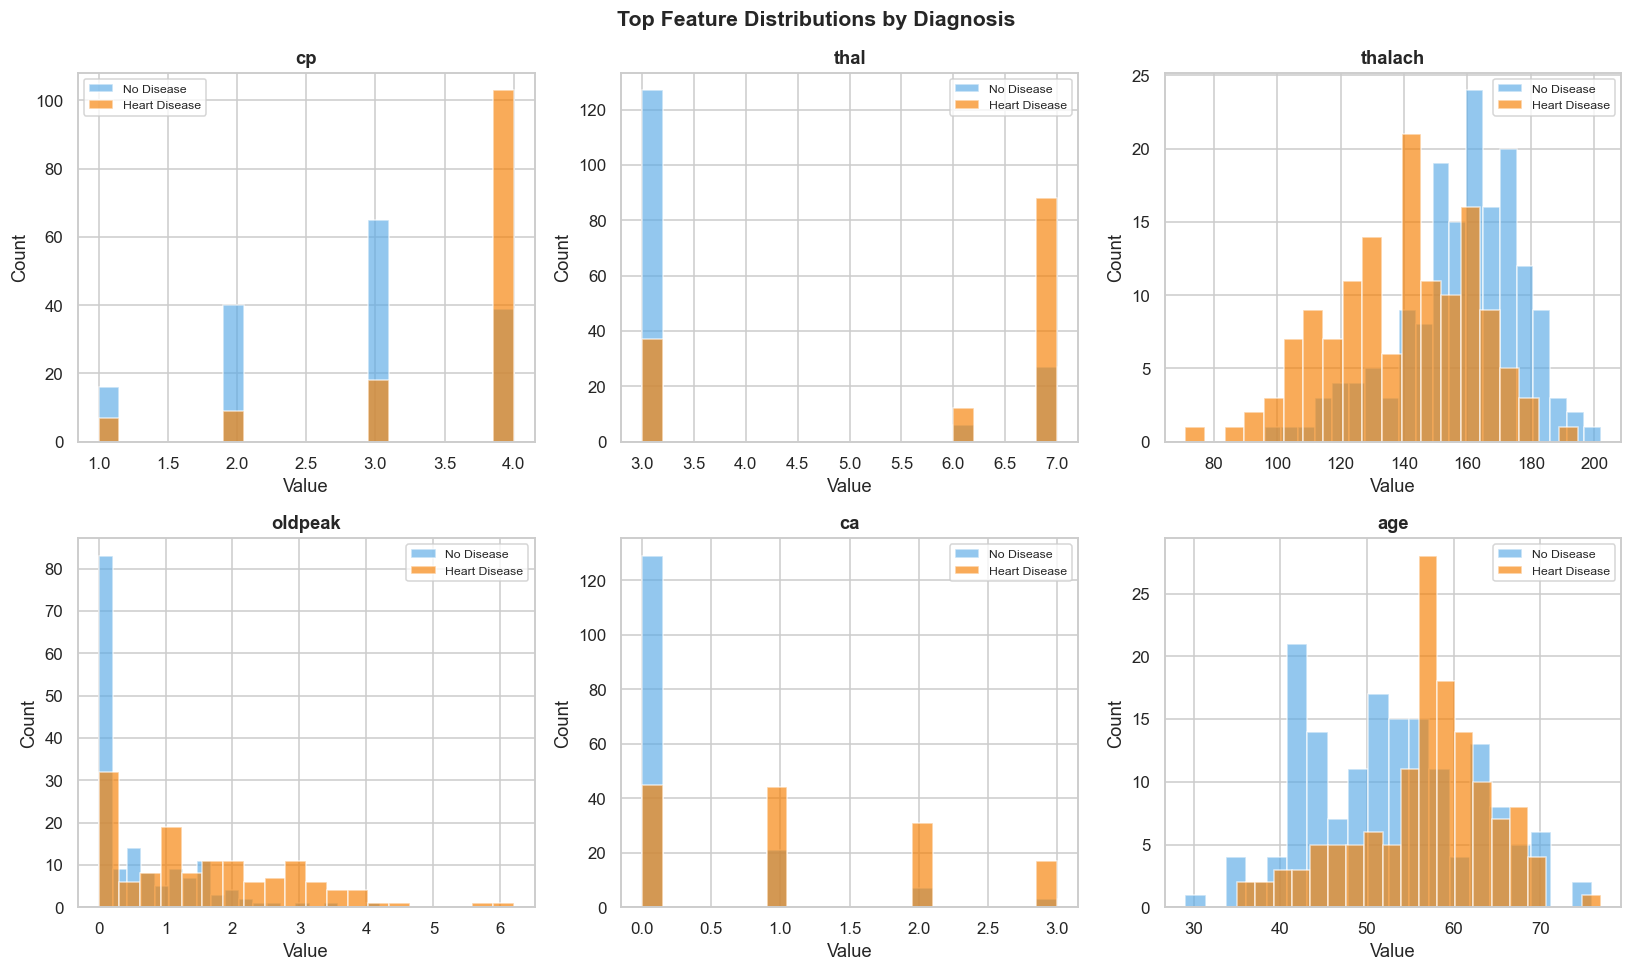

In [37]:
#  Top features: distribution by class 
top_feats = importances.sort_values(ascending=False).head(6).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

for i, feat in enumerate(top_feats):
    for t, label, color in zip([0,1],['No Disease','Heart Disease'],['#5aa9e6','#f77f00']):
        axes[i].hist(df[df['target']==t][feat], bins=20, alpha=0.65,
                     color=color, label=label, edgecolor='white')
    axes[i].set_title(f'{feat}', fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].legend(fontsize=8)

plt.suptitle('Top Feature Distributions by Diagnosis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Predict for a New Patient

In [38]:

new_patient = pd.DataFrame([{
    'age'     : 55,   # years
    'sex'     : 1,    # 1=Male, 0=Female
    'cp'      : 0,    # 0=Typical Angina
    'trestbps': 140,  # resting BP
    'chol'    : 250,  # cholesterol
    'fbs'     : 1,    # fasting blood sugar > 120
    'restecg' : 1,    # ST-T abnormality
    'thalach' : 145,  # max heart rate
    'exang'   : 1,    # exercise-induced angina
    'oldpeak' : 2.0,  # ST depression
    'slope'   : 1,    # slope of ST segment
    'ca'      : 1,    # major vessels
    'thal'    : 2,    # reversible defect
}])

new_patient_sc = scaler.transform(new_patient)

for name, model, data in [('Logistic Regression', lr, new_patient_sc),
                           ('Decision Tree',       dt, new_patient),
                           ('Random Forest',       rf, new_patient)]:
    prob = model.predict_proba(data)[0][1]
    pred = model.predict(data)[0]
    risk = '⚠️  HIGH RISK — Heart Disease Likely' if pred == 1 else '✅  LOW RISK — No Heart Disease Predicted'
    print(f"{name:<25}  Probability: {prob:.1%}  →  {risk}")

Logistic Regression        Probability: 10.4%  →  ✅  LOW RISK — No Heart Disease Predicted
Decision Tree              Probability: 0.0%  →  ✅  LOW RISK — No Heart Disease Predicted
Random Forest              Probability: 40.6%  →  ✅  LOW RISK — No Heart Disease Predicted
